Getting started using this brown dwarf metric notebook as a guide: https://github.com/yoachim/LSST-BD-Cadence/blob/main/bd_dist_metric.ipynb

In [32]:
from lsst.sims.maf.metrics.baseMetric import BaseMetric
import lsst.sims.maf.utils as mafUtils
import lsst.sims.utils as utils
from scipy import interpolate

%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import healpy as hp
import astropy.units as u
from astropy.io import ascii, fits
import glob

import lsst.sims.maf.db as db
import lsst.sims.maf.utils as utils
import lsst.sims.maf.metrics as metrics
import lsst.sims.maf.slicers as slicers
import lsst.sims.maf.stackers as stackers
import lsst.sims.maf.metricBundles as metricBundles
import lsst.sims.maf.maps as maps

In [33]:
from mafContrib.lssmetrics import depthLimitedNumGalMetric
from mafContrib.LSSObsStrategy.galaxyCountsMetric_extended import GalaxyCountsMetric_extended \
    as GalaxyCountsMetric

In [34]:
lv_dat0 = fits.getdata('lsst_galaxies_1p25to9Mpc_table.fits')

In [35]:
lv_dat_cuts = (lv_dat0['dec'] < 35.0) & (lv_dat0['MStars'] > 1e7)
lv_dat = lv_dat0[lv_dat_cuts]

In [36]:
dblist = []
glob_dirs17 = glob.glob('/sims_maf/fbs_1.7/*')
for globdir in glob_dirs17:
    tmpglob = glob.glob(globdir+'/*.db')
    for dbname in tmpglob:
        dblist.append(dbname)
        
glob_dirs171 = glob.glob('/sims_maf/fbs_1.7.1/*')
for globdir in glob_dirs171:
    tmpglob = glob.glob(globdir+'/*.db')
    for dbname in tmpglob:
        dblist.append(dbname)
        
glob_dirs16 = glob.glob('/sims_maf/fbs_1.6/*')
for globdir in glob_dirs16:
    tmpglob = glob.glob(globdir+'/*.db')
    for dbname in tmpglob:
        dblist.append(dbname)

glob_dirs15 = glob.glob('/sims_maf/fbs_1.5/*')
for globdir in glob_dirs15:
    tmpglob = glob.glob(globdir+'/*.db')
    for dbname in tmpglob:
        dblist.append(dbname)

glob_dirs15sso = glob.glob('/sims_maf/fbs_1.5_sso/*')
for globdir in glob_dirs15sso:
    tmpglob = glob.glob(globdir+'/*.db')
    for dbname in tmpglob:
        dblist.append(dbname)

glob_dirs16sso = glob.glob('/sims_maf/fbs_1.6_sso/*')
for globdir in glob_dirs16sso:
    tmpglob = glob.glob(globdir+'/*.db')
    for dbname in tmpglob:
        dblist.append(dbname)


In [37]:
dblist

['/sims_maf/fbs_1.7/baseline/baseline_nexp1_v1.7_10yrs.db',
 '/sims_maf/fbs_1.7/baseline/baseline_nexp2_v1.7_10yrs.db',
 '/sims_maf/fbs_1.7/ddf_dither/ddf_dither0.00_v1.7_10yrs.db',
 '/sims_maf/fbs_1.7/ddf_dither/ddf_dither0.05_v1.7_10yrs.db',
 '/sims_maf/fbs_1.7/ddf_dither/ddf_dither0.10_v1.7_10yrs.db',
 '/sims_maf/fbs_1.7/ddf_dither/ddf_dither0.30_v1.7_10yrs.db',
 '/sims_maf/fbs_1.7/ddf_dither/ddf_dither0.70_v1.7_10yrs.db',
 '/sims_maf/fbs_1.7/ddf_dither/ddf_dither1.00_v1.7_10yrs.db',
 '/sims_maf/fbs_1.7/ddf_dither/ddf_dither1.50_v1.7_10yrs.db',
 '/sims_maf/fbs_1.7/ddf_dither/ddf_dither2.00_v1.7_10yrs.db',
 '/sims_maf/fbs_1.7/euclid_dither/euclid_dither1_v1.7_10yrs.db',
 '/sims_maf/fbs_1.7/euclid_dither/euclid_dither2_v1.7_10yrs.db',
 '/sims_maf/fbs_1.7/euclid_dither/euclid_dither3_v1.7_10yrs.db',
 '/sims_maf/fbs_1.7/euclid_dither/euclid_dither4_v1.7_10yrs.db',
 '/sims_maf/fbs_1.7/euclid_dither/euclid_dither5_v1.7_10yrs.db',
 '/sims_maf/fbs_1.7/footprint_tune/footprint_0_v1.710yrs.db

In [38]:
nside = 16 # 64
sql = 'filter="g" or filter="i"'
sql_i = 'filter = "i"'
sql_g = 'filter = "g"'
sql_r = 'filter = "r"'


In [86]:
bundleList = []

for dbname in dblist:
    dbFile = dbname
    runName = dbFile.replace('.db', '')
    conn = db.OpsimDatabase(dbFile)
    outDir='temp'
    resultsDb = db.ResultsDb(outDir=outDir)
    
    slicer = slicers.UserPointsSlicer(lv_dat['ra'], lv_dat['dec'])
    plotDict = {}

    metric_ngal = GalaxyCountsMetric(nside=nside, metricName='numGal')
    bundleList.append(metricBundles.MetricBundle(metric_ngal, slicer, sql_i, plotDict=plotDict,
                                                 runName=runName))

    mafMap = maps.StellarDensityMap()
    #metric_nstar = metrics.StarDensityMetric(rmagLimit=26.865, metricName='nstars_rmag<medianM5')
    #bundleList.append(metricBundles.MetricBundle(metric_nstar,slicer, sql, mapsList=[mafMap], plotDict=plotDict, runName=runName))

    metric_nstar24 = metrics.StarDensityMetric(rmagLimit=24, metricName='nstars_rmag<24')
    metric_nstar24p5 = metrics.StarDensityMetric(rmagLimit=24.5, metricName='nstars_rmag<24.5')
    metric_nstar25 = metrics.StarDensityMetric(rmagLimit=25, metricName='nstars_rmag<25')
    metric_nstar25p5 = metrics.StarDensityMetric(rmagLimit=25.5, metricName='nstars_rmag<25.5')
    metric_nstar26 = metrics.StarDensityMetric(rmagLimit=26, metricName='nstars_rmag<26')
    metric_nstar26p5 = metrics.StarDensityMetric(rmagLimit=26.5, metricName='nstars_rmag<26.5')
    metric_nstar27 = metrics.StarDensityMetric(rmagLimit=27, metricName='nstars_rmag<27')
    bundleList.append(metricBundles.MetricBundle(metric_nstar24, slicer, sql, mapsList=[mafMap], plotDict=plotDict, runName=runName))
    bundleList.append(metricBundles.MetricBundle(metric_nstar24p5, slicer, sql, mapsList=[mafMap], plotDict=plotDict, runName=runName))
    bundleList.append(metricBundles.MetricBundle(metric_nstar25, slicer, sql, mapsList=[mafMap], plotDict=plotDict, runName=runName))
    bundleList.append(metricBundles.MetricBundle(metric_nstar25p5, slicer, sql, mapsList=[mafMap], plotDict=plotDict, runName=runName))
    bundleList.append(metricBundles.MetricBundle(metric_nstar26, slicer, sql, mapsList=[mafMap], plotDict=plotDict, runName=runName))
    bundleList.append(metricBundles.MetricBundle(metric_nstar26p5, slicer, sql, mapsList=[mafMap], plotDict=plotDict, runName=runName))
    bundleList.append(metricBundles.MetricBundle(metric_nstar27, slicer, sql, mapsList=[mafMap], plotDict=plotDict, runName=runName))

    metric_coadd = metrics.Coaddm5Metric()
    bundleList.append(metricBundles.MetricBundle(metric_coadd, slicer, sql_i, plotDict=plotDict, runName=runName))
    bundleList.append(metricBundles.MetricBundle(metric_coadd, slicer, sql_g, plotDict=plotDict, runName=runName))
    bundleList.append(metricBundles.MetricBundle(metric_coadd, slicer, sql_r, plotDict=plotDict, runName=runName))
    

bd = metricBundles.makeBundlesDictFromList(bundleList)
bg = metricBundles.MetricBundleGroup(bd, conn, outDir=outDir, resultsDb=resultsDb)
bg.runAll()


Querying database SummaryAllProps with constraint filter = "g" for columns ['fieldDec', 'fiveSigmaDepth', 'fieldRA']
Found 213644 visits
Running:  ['_sims_maf_fbs_1_7_baseline_baseline_nexp1_v1_7_10yrs_CoaddM5_g_USER']
Completed metric generation.
Running:  ['_sims_maf_fbs_1_7_baseline_baseline_nexp2_v1_7_10yrs_CoaddM5_g_USER']
Completed metric generation.
Running:  ['_sims_maf_fbs_1_7_ddf_dither_ddf_dither0_00_v1_7_10yrs_CoaddM5_g_USER']
Completed metric generation.
Running:  ['_sims_maf_fbs_1_7_ddf_dither_ddf_dither0_05_v1_7_10yrs_CoaddM5_g_USER']
Completed metric generation.
Running:  ['_sims_maf_fbs_1_7_ddf_dither_ddf_dither0_10_v1_7_10yrs_CoaddM5_g_USER']
Completed metric generation.
Running:  ['_sims_maf_fbs_1_7_ddf_dither_ddf_dither0_30_v1_7_10yrs_CoaddM5_g_USER']
Completed metric generation.
Running:  ['_sims_maf_fbs_1_7_ddf_dither_ddf_dither0_70_v1_7_10yrs_CoaddM5_g_USER']
Completed metric generation.
Running:  ['_sims_maf_fbs_1_7_ddf_dither_ddf_dither1_00_v1_7_10yrs_CoaddM5_g

In [87]:
'''
#first: compute integrated mag in B:
LF = ascii.read('LF_-1.5_10Gyr_B.dat', header_start=12)
mags = LF['magbinc']
counts = LF['Bmag']
intBmag = -2.5*np.log10( np.sum(counts * np.power(10.0,-0.4*mags) ))
print ('intMag='+str(intBmag))
#result is 6.856379, store it for later
'''

# make fake LF for old galaxy of given integrated B, distance modulus mu, in any of filters ugrizY
def makeFakeLF(intB, mu, filtername): 
    if (filtername=='y'): filtername=='Y'
    modelBmag = 6.856379 # integrated B mag of the model LF being read
    LF = ascii.read('LF_-1.5_10Gyr.dat', header_start=12)
    mags = LF['magbinc']
    counts = LF[filtername+'mag']
    # shift model LF to requested distance and dim it
    mags = mags + mu
    modelBmag = modelBmag + mu
    # scale model counts up/down to reach the requested intB
    factor = np.power(10.0,-0.4*(intB-modelBmag))
    counts = factor * counts
    # resample from Poisson:
    return mags, counts
#    countsPoisson = np.random.poisson(counts)
#    return mags, countsPoisson
    
#test: now will make a fake LF for 47Tuc, with intB=5.78, mu0=13.32
#intB=5.78
#mu0=13.32
#LFmags,LFcounts = makeFakeLF(intB,mu0,'r')
#for i in range(len(LFmags)):
#    print (LFmags[i],LFcounts[i])


In [88]:
lf_dict_i = {}
lf_dict_g = {}
tmp_MB = -10.0

for i in range(101):
    mbkey = f'MB{tmp_MB:.2f}'
    iLFmags,iLFcounts = makeFakeLF(tmp_MB, 0.0, 'i')
    lf_dict_i[mbkey] = (np.array(iLFmags), np.array(iLFcounts))
    gLFmags,gLFcounts = makeFakeLF(tmp_MB, 0.0, 'g')
    lf_dict_g[mbkey] = (np.array(gLFmags), np.array(gLFcounts))
    tmp_MB += 0.1

In [104]:
def sum_luminosity(LFmags, LFcounts):
    magref = LFmags[0]
    totlum = 0.0
    
    for mag, count in zip(LFmags, LFcounts):
        tmpmags = np.repeat(mag, count)
        totlum += np.sum(10.0**((magref - tmpmags)/2.5))

    mtot = magref-2.5*np.log10(totlum)
    return mtot
    
def sblimit(mags_g, mags_i, nstars_req, distlim):
    distance_limit = distlim*1e6 # distance limit in parsecs
    distmod_limit = 5.0*np.log10(distance_limit) - 5.0

    mg_lim = []
    mi_lim = []
    sbg_lim = []
    sbi_lim = []
    flag_lim = []
    
    for glim, ilim, nstars, distmod_lim in zip(mags_g, mags_i, nstars_req, distmod_limit):
    # for i in range(len(mags_g)):
        if (glim > 15) and (ilim > 15):
            # print(glim, ilim, nstars)
            fake_MB = -10.0
            ng = 1e6
            ni = 1e6
    
            while (ng > nstars) and (ni > nstars) and fake_MB<-2.0:
                # B_fake = distmod_limit+fake_MB
                mbkey = f'MB{fake_MB:.2f}'
                iLFmags0,iLFcounts0 = lf_dict_i[mbkey]
                gLFmags0,gLFcounts0 = lf_dict_g[mbkey]
                iLFcounts = np.random.poisson(iLFcounts0)
                gLFcounts = np.random.poisson(gLFcounts0)
                iLFmags = iLFmags0+distmod_lim # Add the distance modulus to make it apparent mags
                gLFmags = gLFmags0+distmod_lim # Add the distance modulus to make it apparent mags
                # print(iLFcounts0-iLFcounts)
                gsel = (gLFmags <= glim)
                isel = (iLFmags <= ilim)
                ng = np.sum(gLFcounts[gsel])
                ni = np.sum(iLFcounts[isel])
                # print('fake_MB: ',fake_MB, ' ng: ',ng, ' ni: ', ni, ' nstars: ', nstars)
                fake_MB += 0.1
            
            if fake_MB > -9.9:
                gmag_tot = sum_luminosity(gLFmags[gsel], gLFcounts[gsel]) - distmod_lim
                imag_tot = sum_luminosity(iLFmags[isel], iLFcounts[isel]) - distmod_lim
                # S = m + 2.5logA, where in this case things are in sq. arcmin, so A = 1 arcmin^2 = 3600 arcsec^2
                sbtot_g = distmod_lim + gmag_tot + 2.5*np.log10(3600.0)
                sbtot_i = distmod_lim + imag_tot + 2.5*np.log10(3600.0)
                mg_lim.append(gmag_tot)
                mi_lim.append(imag_tot)
                sbg_lim.append(sbtot_g)
                sbi_lim.append(sbtot_i)
                if (ng < ni):
                    flag_lim.append('g')
                else:
                    flag_lim.append('i')
            else:
                mg_lim.append(999.9)
                mi_lim.append(999.9)
                sbg_lim.append(999.9)
                sbi_lim.append(999.9)
                flag_lim.append('none')
        else:
            mg_lim.append(999.9)
            mi_lim.append(999.9)
            sbg_lim.append(-999.9)
            sbi_lim.append(-999.9)
            flag_lim.append('none')
        
    return mg_lim, mi_lim, sbg_lim, sbi_lim, flag_lim


In [90]:
# Calculate the factor to go from number per healpix to number per square arcminute or per square arcsec
pixarea_deg = hp.nside2pixarea(nside, degrees=True)*(u.degree**2)
pixarea_arcmin = pixarea_deg.to(u.arcmin**2)
pixarea_arcsec = pixarea_deg.to(u.arcsec**2)

# Account for:
#  - cmd_frac: fraction of CMD area being selected
#  - stargal_contamination: what fraction of objects in your "star" selection after star-galaxy separation are background galaxy contaminants?

cmd_frac = 0.1
stargal_contamination = 0.40
nsigma = 10.0


In [105]:
names = []
mg_lims = []
mi_lims = []
mv_lims = []
sb_g_lims = []
sb_i_lims = []
sb_v_lims = []
nbelow_mv_7 = []

for run in dblist[0:15]:
    runName = run.replace('.db', '')
    root0 = str.replace(runName, '/', '_')
    root = str.replace(root0, '.', '_')

    i5 = bg.bundleDict[root+'_CoaddM5_i_USER'].metricValues
    g5 = bg.bundleDict[root+'_CoaddM5_g_USER'].metricValues
    r5 = bg.bundleDict[root+'_CoaddM5_r_USER'].metricValues

    ngal = bg.bundleDict[root+'_numGal_i_USER'].metricValues
    # nstar = bg.bundleDict[root+'_nstars_rmagltmedianM5_g_or_i_USER'].metricValues
    # Just use the r<27 values for the "total" number of stars:
    nstar = bg.bundleDict[root+'_nstars_rmaglt27_g_or_i_USER'].metricValues

    nstar_r24 = bg.bundleDict[root+'_nstars_rmaglt24_g_or_i_USER'].metricValues
    nstar_r24p5 = bg.bundleDict[root+'_nstars_rmaglt24_5_g_or_i_USER'].metricValues
    nstar_r25 = bg.bundleDict[root+'_nstars_rmaglt25_g_or_i_USER'].metricValues
    nstar_r25p5 = bg.bundleDict[root+'_nstars_rmaglt25_5_g_or_i_USER'].metricValues
    nstar_r26 = bg.bundleDict[root+'_nstars_rmaglt26_g_or_i_USER'].metricValues
    nstar_r26p5 = bg.bundleDict[root+'_nstars_rmaglt26_5_g_or_i_USER'].metricValues
    nstar_r27 = bg.bundleDict[root+'_nstars_rmaglt27_g_or_i_USER'].metricValues

    nstar_all = nstar*0.0
    rbinvals = np.arange(24.0, 27.5, 0.5)
    rbinnames = [nstar_r24, nstar_r24p5, nstar_r25, nstar_r25p5, nstar_r26, nstar_r26p5, nstar_r27]

    for binval,bindensity in zip(rbinvals, rbinnames):
        inbin = np.where(np.abs(r5-binval) < 0.25)
        nstar_all[inbin] = bindensity[inbin]

    outside_faint = (r5 >= 27.25)
    outside_bright = (r5 <= 23.75)
    nstar_all[outside_faint] = nstar[outside_faint]
    nstar_all[outside_bright] = nstar_r24[outside_bright]

    # Star density is number of stars per square arcsec. Convert to a total number per healpix, then number per sq. arcmin:
    nstar_all_per_healpix = nstar_all*pixarea_arcsec
    nstar_all_per_arcmin = nstar_all_per_healpix/pixarea_arcmin
    
    # Number of galaxies is the total in each healpix. Convert to number per sq. arcmin:
    ngal_per_arcmin = ngal/pixarea_arcmin

    # Star density is number of stars per square arcsec. Convert to a total number per healpix, then number per sq. arcmin:
    nstar_per_healpix = nstar*pixarea_arcsec
    nstar_per_arcmin = nstar_per_healpix/pixarea_arcmin
    
    nstars_required = nsigma*np.sqrt(ngal_per_arcmin*(cmd_frac*stargal_contamination)+(nstar_all_per_arcmin*cmd_frac))

    mg_lim, mi_lim, sb_g_lim, sb_i_lim, flag_lim = sblimit(g5, i5, nstars_required, distlim=lv_dat['dist_Mpc'])

    names.append(run)
    mg_lims.append(mg_lim)
    mi_lims.append(mi_lim)
    sb_g_lims.append(sb_g_lim)
    sb_i_lims.append(sb_i_lim)
    

In [106]:
mg_medians = []
mi_medians = []
mv_medians = []
sbg_medians = []
sbi_medians = []
sbv_medians = []
nbelow_mv7 = []
maxdist = []

for mg, mi, sbg, sbi in zip(mg_lims, mi_lims, sb_g_lims, sb_i_lims):
    mg = np.array(mg)
    mi = np.array(mi)
    sbg = np.array(sbg)
    sbi = np.array(sbi)

    okgx = (np.abs(sbi) < 90) & (np.abs(sbg) < 90) & (np.abs(mi) < 90) & (np.abs(mg) < 90)

    # okmg = (np.abs(mg) < 90)
    # print(np.median(mg[okmg]))
    
    # Use the conversion from Appendix A of Komiyama+2018, ApJ, 853, 29:
    # V = g_hsc - 0.371*(gi_hsc)-0.068
    mv = mg-0.371*(mg-mi)-0.068
    sbv = sbg-0.371*(sbg-sbi)-0.068
    
    mg_medians.append(np.median(mg[okgx]))
    mi_medians.append(np.median(mi[okgx]))
    mv_medians.append(np.median(mv[okgx]))
    sbg_medians.append(np.median(sbg[okgx]))
    sbi_medians.append(np.median(sbi[okgx]))
    sbv_medians.append(np.median(sbv[okgx]))
    maxdist.append(np.max(lv_dat[okgx]['Dist_Mpc']))
    nbelow_mv7.append(len(lv_dat[(mv > -7) & (mv < 0)]))

#print(len(lv_dat), len(lv_dat[(mv > -7) & (mv < 0)]))

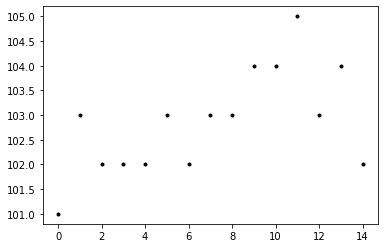

In [107]:
plt.plot(nbelow_mv7, 'k.')
#plt.plot(nbelow_mv7, 'k')
#plt.plot(mv_medians, nbelow_mv7, 'k.')
#plt.plot(sbv_medians, nbelow_mv7, 'k.')
plt.show()

In [94]:
np.min(mv[okgx])

-7.1196592488089525

In [100]:
names

['/sims_maf/fbs_1.7/baseline/baseline_nexp1_v1.7_10yrs.db',
 '/sims_maf/fbs_1.7/baseline/baseline_nexp2_v1.7_10yrs.db',
 '/sims_maf/fbs_1.7/ddf_dither/ddf_dither0.00_v1.7_10yrs.db',
 '/sims_maf/fbs_1.7/ddf_dither/ddf_dither0.05_v1.7_10yrs.db',
 '/sims_maf/fbs_1.7/ddf_dither/ddf_dither0.10_v1.7_10yrs.db',
 '/sims_maf/fbs_1.7/ddf_dither/ddf_dither0.30_v1.7_10yrs.db',
 '/sims_maf/fbs_1.7/ddf_dither/ddf_dither0.70_v1.7_10yrs.db',
 '/sims_maf/fbs_1.7/ddf_dither/ddf_dither1.00_v1.7_10yrs.db',
 '/sims_maf/fbs_1.7/ddf_dither/ddf_dither1.50_v1.7_10yrs.db',
 '/sims_maf/fbs_1.7/ddf_dither/ddf_dither2.00_v1.7_10yrs.db',
 '/sims_maf/fbs_1.7/euclid_dither/euclid_dither1_v1.7_10yrs.db',
 '/sims_maf/fbs_1.7/euclid_dither/euclid_dither2_v1.7_10yrs.db',
 '/sims_maf/fbs_1.7/euclid_dither/euclid_dither3_v1.7_10yrs.db',
 '/sims_maf/fbs_1.7/euclid_dither/euclid_dither4_v1.7_10yrs.db',
 '/sims_maf/fbs_1.7/euclid_dither/euclid_dither5_v1.7_10yrs.db']

In [108]:
np.sum((mv_medians[0] < 0) & (mv_medians[0] > -7))

1

In [109]:
slicers.UserPointsSlicer?

Init signature:
slicers.UserPointsSlicer(
    ra,
    dec,
    lonCol='fieldRA',
    latCol='fieldDec',
    latLonDeg=True,
    verbose=True,
    badval=-666,
    leafsize=100,
    radius=1.75,
    useCamera=False,
    rotSkyPosColName='rotSkyPos',
    mjdColName='observationStartMJD',
    chipNames='all',
)
Docstring:     
A spatial slicer that evaluates pointings overlapping user-provided list of points.

Parameters
----------
ra : list or numpy.ndarray
    User-selected RA points, in degrees. Stored internally in radians.
dec : list or numpy.ndarray
    User-selected Dec points, in degrees. Stored internally in radians.
lonCol : str, optional
    Name of the longitude (RA equivalent) column to use from the input data.
    Default fieldRA
latCol : str, optional
    Name of the latitude (Dec equivalent) column to use from the input data.
    Default fieldDec
latLonDeg : bool, optional
    Flag indicating whether the lon and lat values will be in degrees (True) or radians (False).
    

In [110]:
flag_lim

['none',
 'g',
 'none',
 'none',
 'g',
 'g',
 'none',
 'g',
 'g',
 'g',
 'g',
 'g',
 'g',
 'g',
 'none',
 'none',
 'none',
 'none',
 'g',
 'none',
 'none',
 'none',
 'g',
 'none',
 'none',
 'none',
 'none',
 'none',
 'none',
 'none',
 'g',
 'g',
 'none',
 'g',
 'g',
 'none',
 'none',
 'none',
 'none',
 'none',
 'g',
 'none',
 'none',
 'none',
 'none',
 'none',
 'none',
 'none',
 'g',
 'none',
 'none',
 'none',
 'none',
 'none',
 'none',
 'none',
 'none',
 'none',
 'none',
 'g',
 'g',
 'none',
 'none',
 'none',
 'none',
 'none',
 'none',
 'none',
 'i',
 'g',
 'none',
 'none',
 'none',
 'none',
 'none',
 'none',
 'none',
 'none',
 'none',
 'g',
 'none',
 'none',
 'none',
 'none',
 'none',
 'none',
 'none',
 'none',
 'none',
 'none',
 'none',
 'none',
 'none',
 'none',
 'none',
 'none',
 'none',
 'none',
 'none',
 'none',
 'g',
 'none',
 'g',
 'none',
 'none',
 'none',
 'i',
 'i',
 'none',
 'g',
 'none',
 'none',
 'none',
 'none',
 'none',
 'none',
 'none',
 'none',
 'none',
 'none',
 'no